In [16]:
# importing Qiskit
from qiskit import (
	IBMQ,
	QuantumCircuit,
	transpile,
)
from qiskit.providers import Backend
from qiskit.providers.aer.noise import NoiseModel
from qiskit.result import Result

import statistics
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import math
import datetime
from IPython.display import display
import os
import time
import pickle
from helpers import get_error_rate, get_error_rate_per_qubit
import colorsys

In [17]:
class Measurement:
	def __init__(self, backend, circs, params):
		self.backend = backend
		self.properties_before = None
		self.properties_before_ts = None
		self.properties_after = None
		self.properties_after_ts = None
		self.properties_runtime = None
		self.properties_runtime_ts = None
		self.result = None
		self.job = None
		self.circuits = circs
		self.circuit_params = params
		self.noise_model = None

	def run(self):
		self.properties_before_ts = datetime.datetime.now()
		self.properties_before = self.backend.properties()

		self.job = self.backend.run(self.circuits, shots=10000)
		self.result = self.job.result().get_counts()
		self.noise_model = NoiseModel.from_backend(self.backend)

		self.properties_runtime_ts = self.job.time_per_step()["RUNNING"]
		self.properties_runtime = self.backend.properties(datetime=self.properties_runtime_ts)

		self.properties_after = self.backend.properties()
		self.properties_after_ts = datetime.datetime.now()

In [18]:
folder = "output_long_experiment"
n = 52
measures = []
for i in range(n):
	with open(os.path.join(folder, f"measurement_{i}"), "rb") as file:
		measures.append(pickle.load(file))

In [19]:
#fix wrong params and results
for m in measures:
	for p in m.circuit_params:
		if isinstance(p["expected result"], set):
			p["expected result"] = {p["expected result"].pop(): 1}
	if isinstance(m.result, Result):
		m.result = m.result.get_counts()

In [20]:
results = []
since_calibration = []
for m in measures:
	res = []
	for r, p in zip(m.result, m.circuit_params):
		expected = p["expected result"]
		res.append(get_error_rate_per_qubit(r, expected))
	if m.properties_runtime_ts < datetime.datetime(2022, 5, 18, 7, 20, 35, tzinfo=datetime.datetime.now().astimezone().tzinfo):
		continue
	results.append(res)
	since_calibration.append((m.properties_runtime_ts - m.properties_runtime.last_update_date).total_seconds() / datetime.timedelta(days=1, hours=2).total_seconds())

results = np.array(results)
print(results.shape)
since_calibration = np.array(since_calibration)
print(since_calibration.shape)

(46, 99, 5)
(46,)


In [21]:
samples = np.linspace(0, 250, 15, dtype=int)[1:]*2
l = samples.size
all = []
qubit_idx = 2
for r in results:
	all.append(r[l*qubit_idx:l*(qubit_idx+1), qubit_idx][3])

all = np.array(all)
print(all.max())
print(all.min())

0.8799
0.16600000000000004


In [22]:
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-07-27 00:06:45,776: Credentials are already in use. The existing account in the session will be replaced.


In [23]:
calibration_dates = []
for m in measures:
	calibration_dates.append(m.properties_runtime.last_update_date)

calibration_dates = np.unique(calibration_dates)

calibration_dates

array([datetime.datetime(2022, 5, 16, 7, 5, 45, tzinfo=tzlocal()),
       datetime.datetime(2022, 5, 18, 7, 20, 35, tzinfo=tzlocal()),
       datetime.datetime(2022, 5, 19, 9, 3, 57, tzinfo=tzlocal())],
      dtype=object)

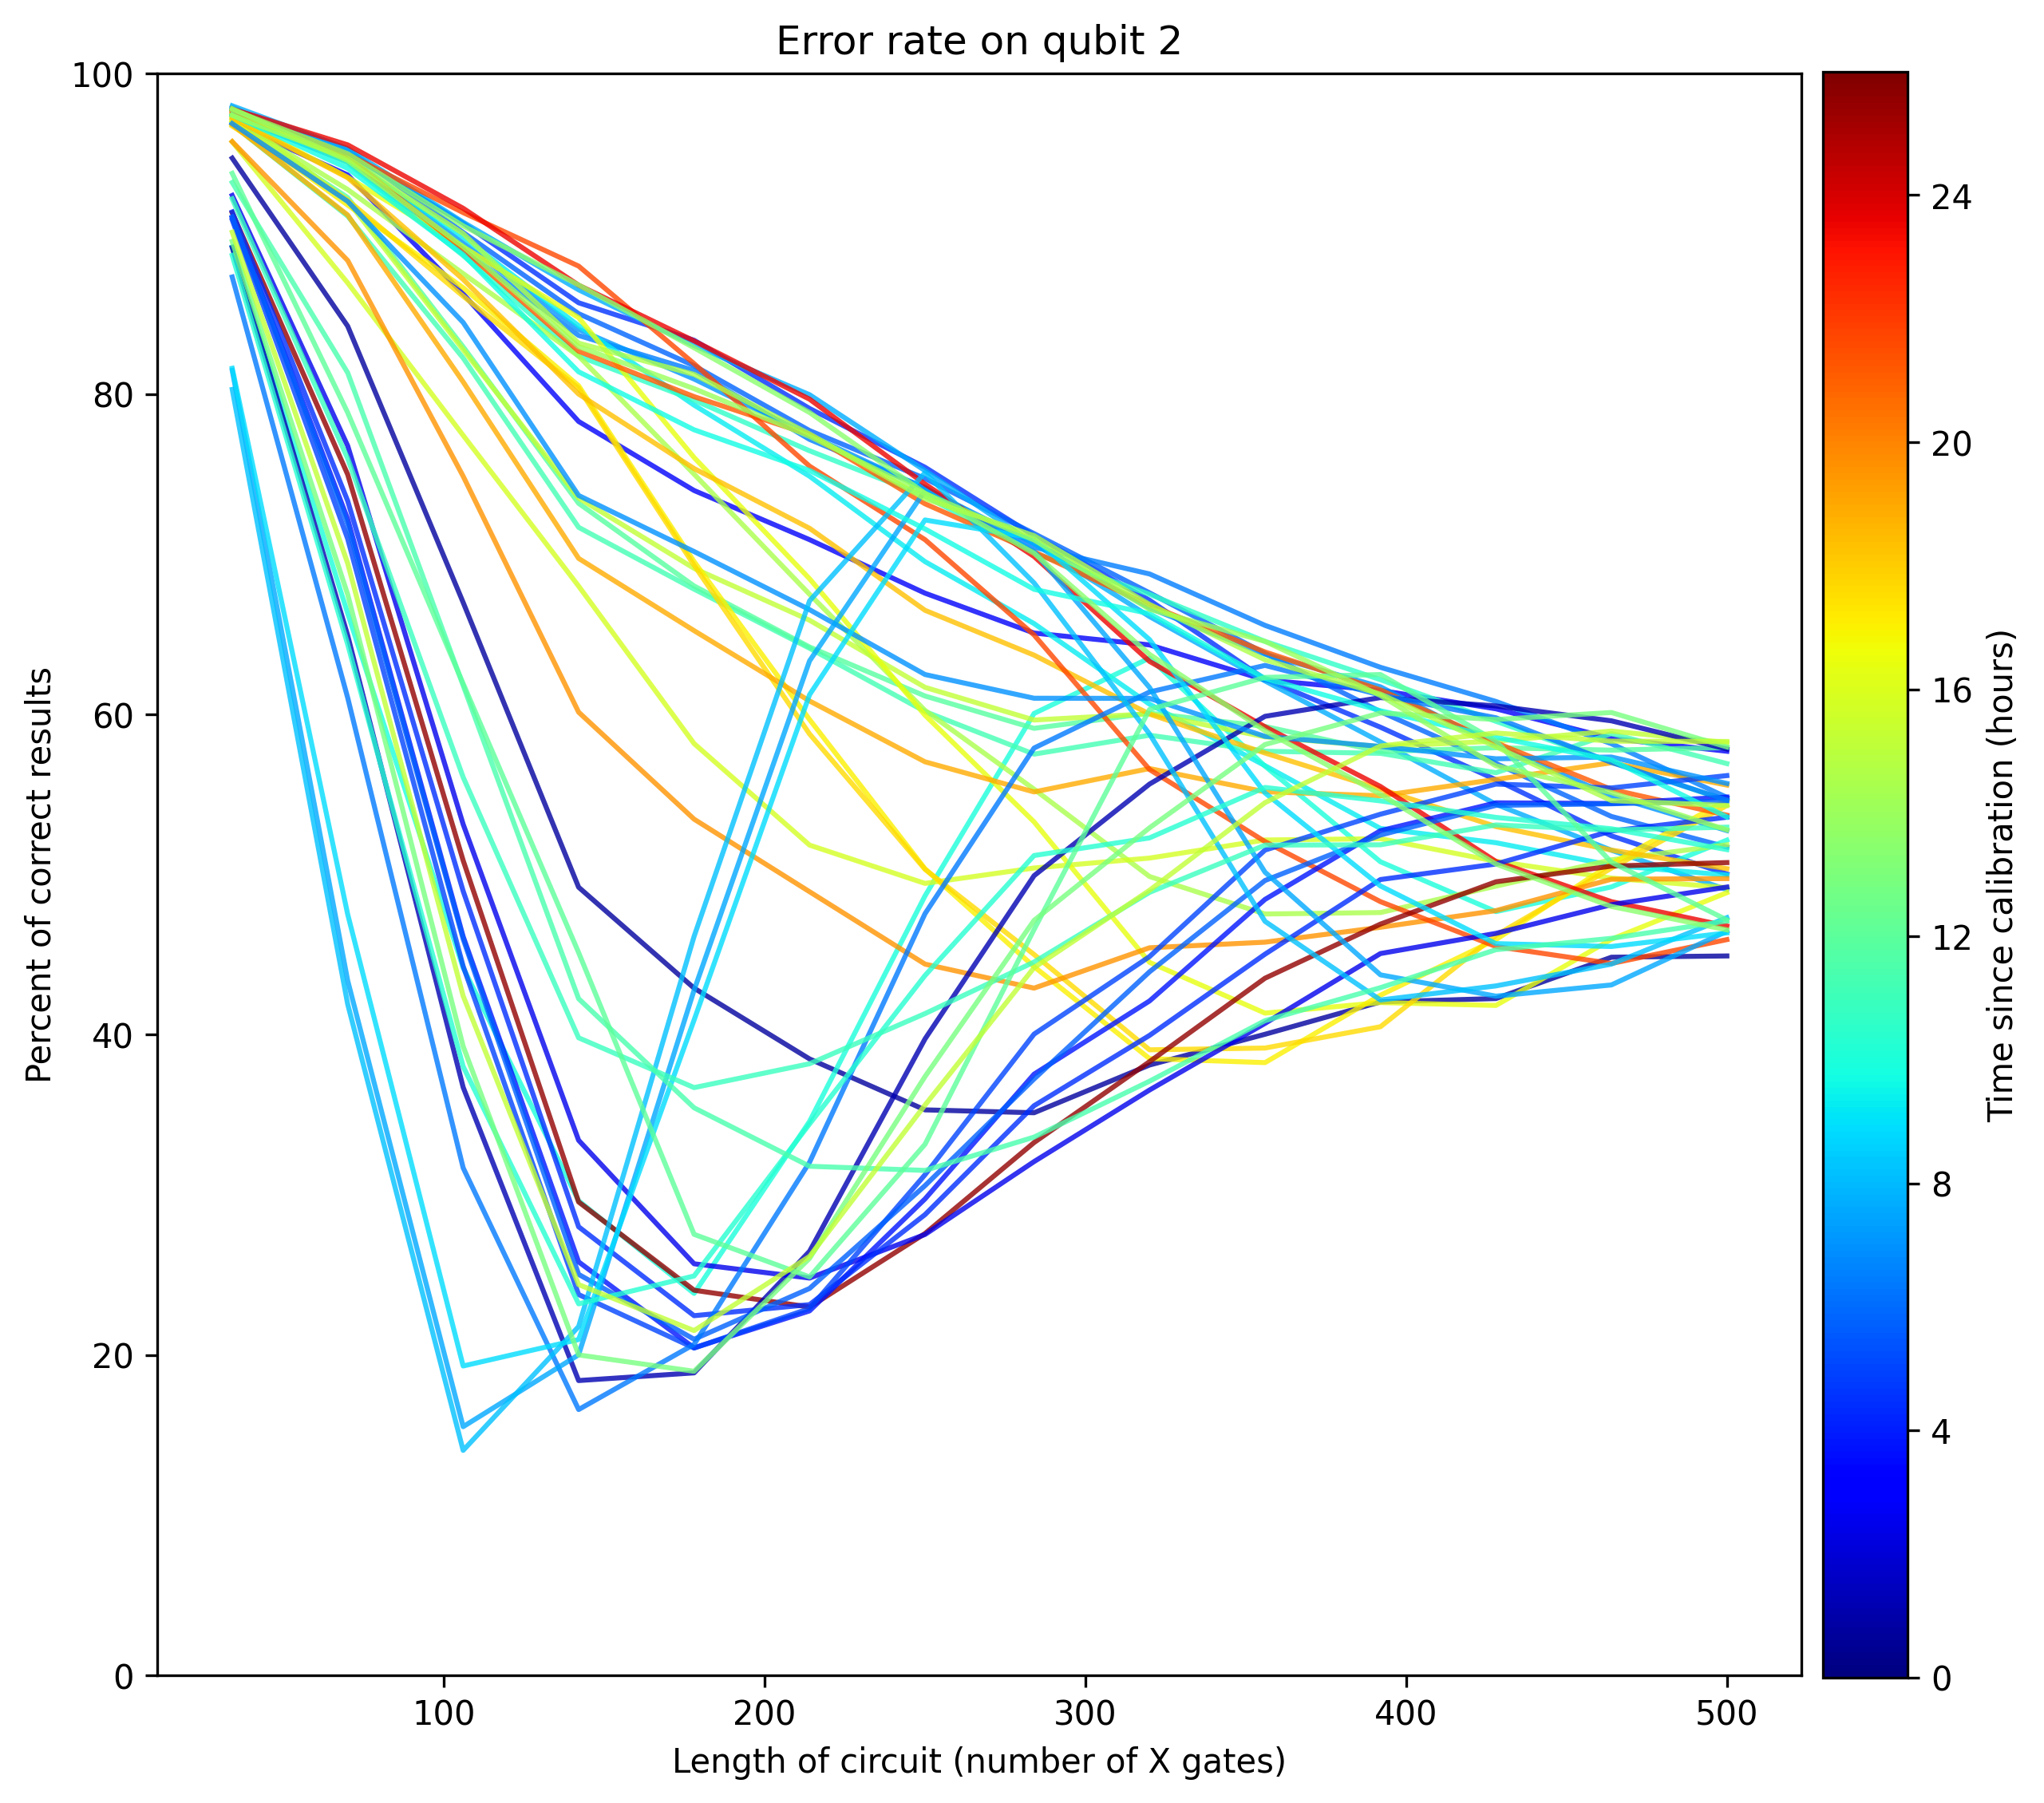

None

In [29]:
samples = np.linspace(0, 250, 15, dtype=int)[1:]*2
l = samples.size
viridis = cm.get_cmap('jet')
factor = 3
figure_width = 5.90666*factor/2
figure_heigth = figure_width
dpi = 300
for i in range(5):
	i = 2
	figure(figsize=(figure_width, figure_heigth), dpi=dpi)
	plt.title(f"Error rate on qubit {i}")
	plt.xlabel(f"Length of circuit (number of X gates)")
	plt.ylabel(f"Percent of correct results")
	plt.ylim(top=100)
	for r, t in zip(results, since_calibration):
		plt.plot(samples, r[l*i:l*(i+1), i]*100, alpha=.8, color=viridis(t))

	norm = matplotlib.colors.Normalize(vmin=0, vmax=26)
	cb_ax = plt.gcf().add_axes([.91,.124,.04,.757])
	cb = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=viridis), cax=cb_ax)
	tick_locator = matplotlib.ticker.MaxNLocator(nbins=8)
	cb.locator = tick_locator
	cb.update_ticks()
	cb.ax.set_ylabel("Time since calibration (hours)")
	plt.savefig(f"../images/multiple_qubit_{i}.png", bbox_inches='tight')
	display(plt.show())
	break

In [25]:
all_not = []
all_not_dates = []
for m in measures:
	res = []
	for r, p in zip(m.result, m.circuit_params):
		if "chained not gates on all qubits" in p["desc"]:
			expected = p["expected result"]
			res.append(get_error_rate_per_qubit(r, expected))
	all_not_dates.append(m.properties_runtime_ts)
	all_not.append(res)
all_not = np.array(all_not)
all_not_dates = np.array(all_not_dates)
print(all_not.shape)
print(all_not_dates.shape)

(52, 14, 5)
(52,)


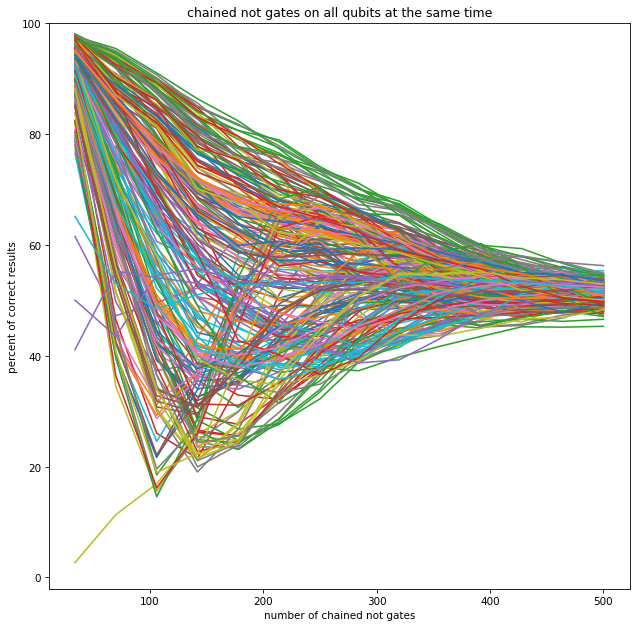

None

In [26]:
samples = np.linspace(0, 250, 15, dtype=int)[1:]*2
figure(figsize=(10, 10), dpi=75)
for r in all_not:
	plt.plot(samples, r[:]*100)
#plt.legend()
plt.title("chained not gates on all qubits at the same time")
plt.ylim(top=100)
plt.ylabel("percent of correct results")
plt.xlabel("number of chained not gates")
#plt.savefig("./images/not_on_all_qubits_error_per_qubit.jpg")
display(plt.show())

In [27]:
all_calibrations = []
for m in measures:
	for l in m.properties_runtime.qubits:
		for ll in l:
			all_calibrations.append(ll.date)
	for g in m.properties_runtime.gates:
		for p in g.parameters:
			all_calibrations.append(p.date)
	for l in m.properties_runtime.general:
		all_calibrations.append(l.date)
all_calibrations = np.unique(all_calibrations)
all_calibrations.shape

(38,)

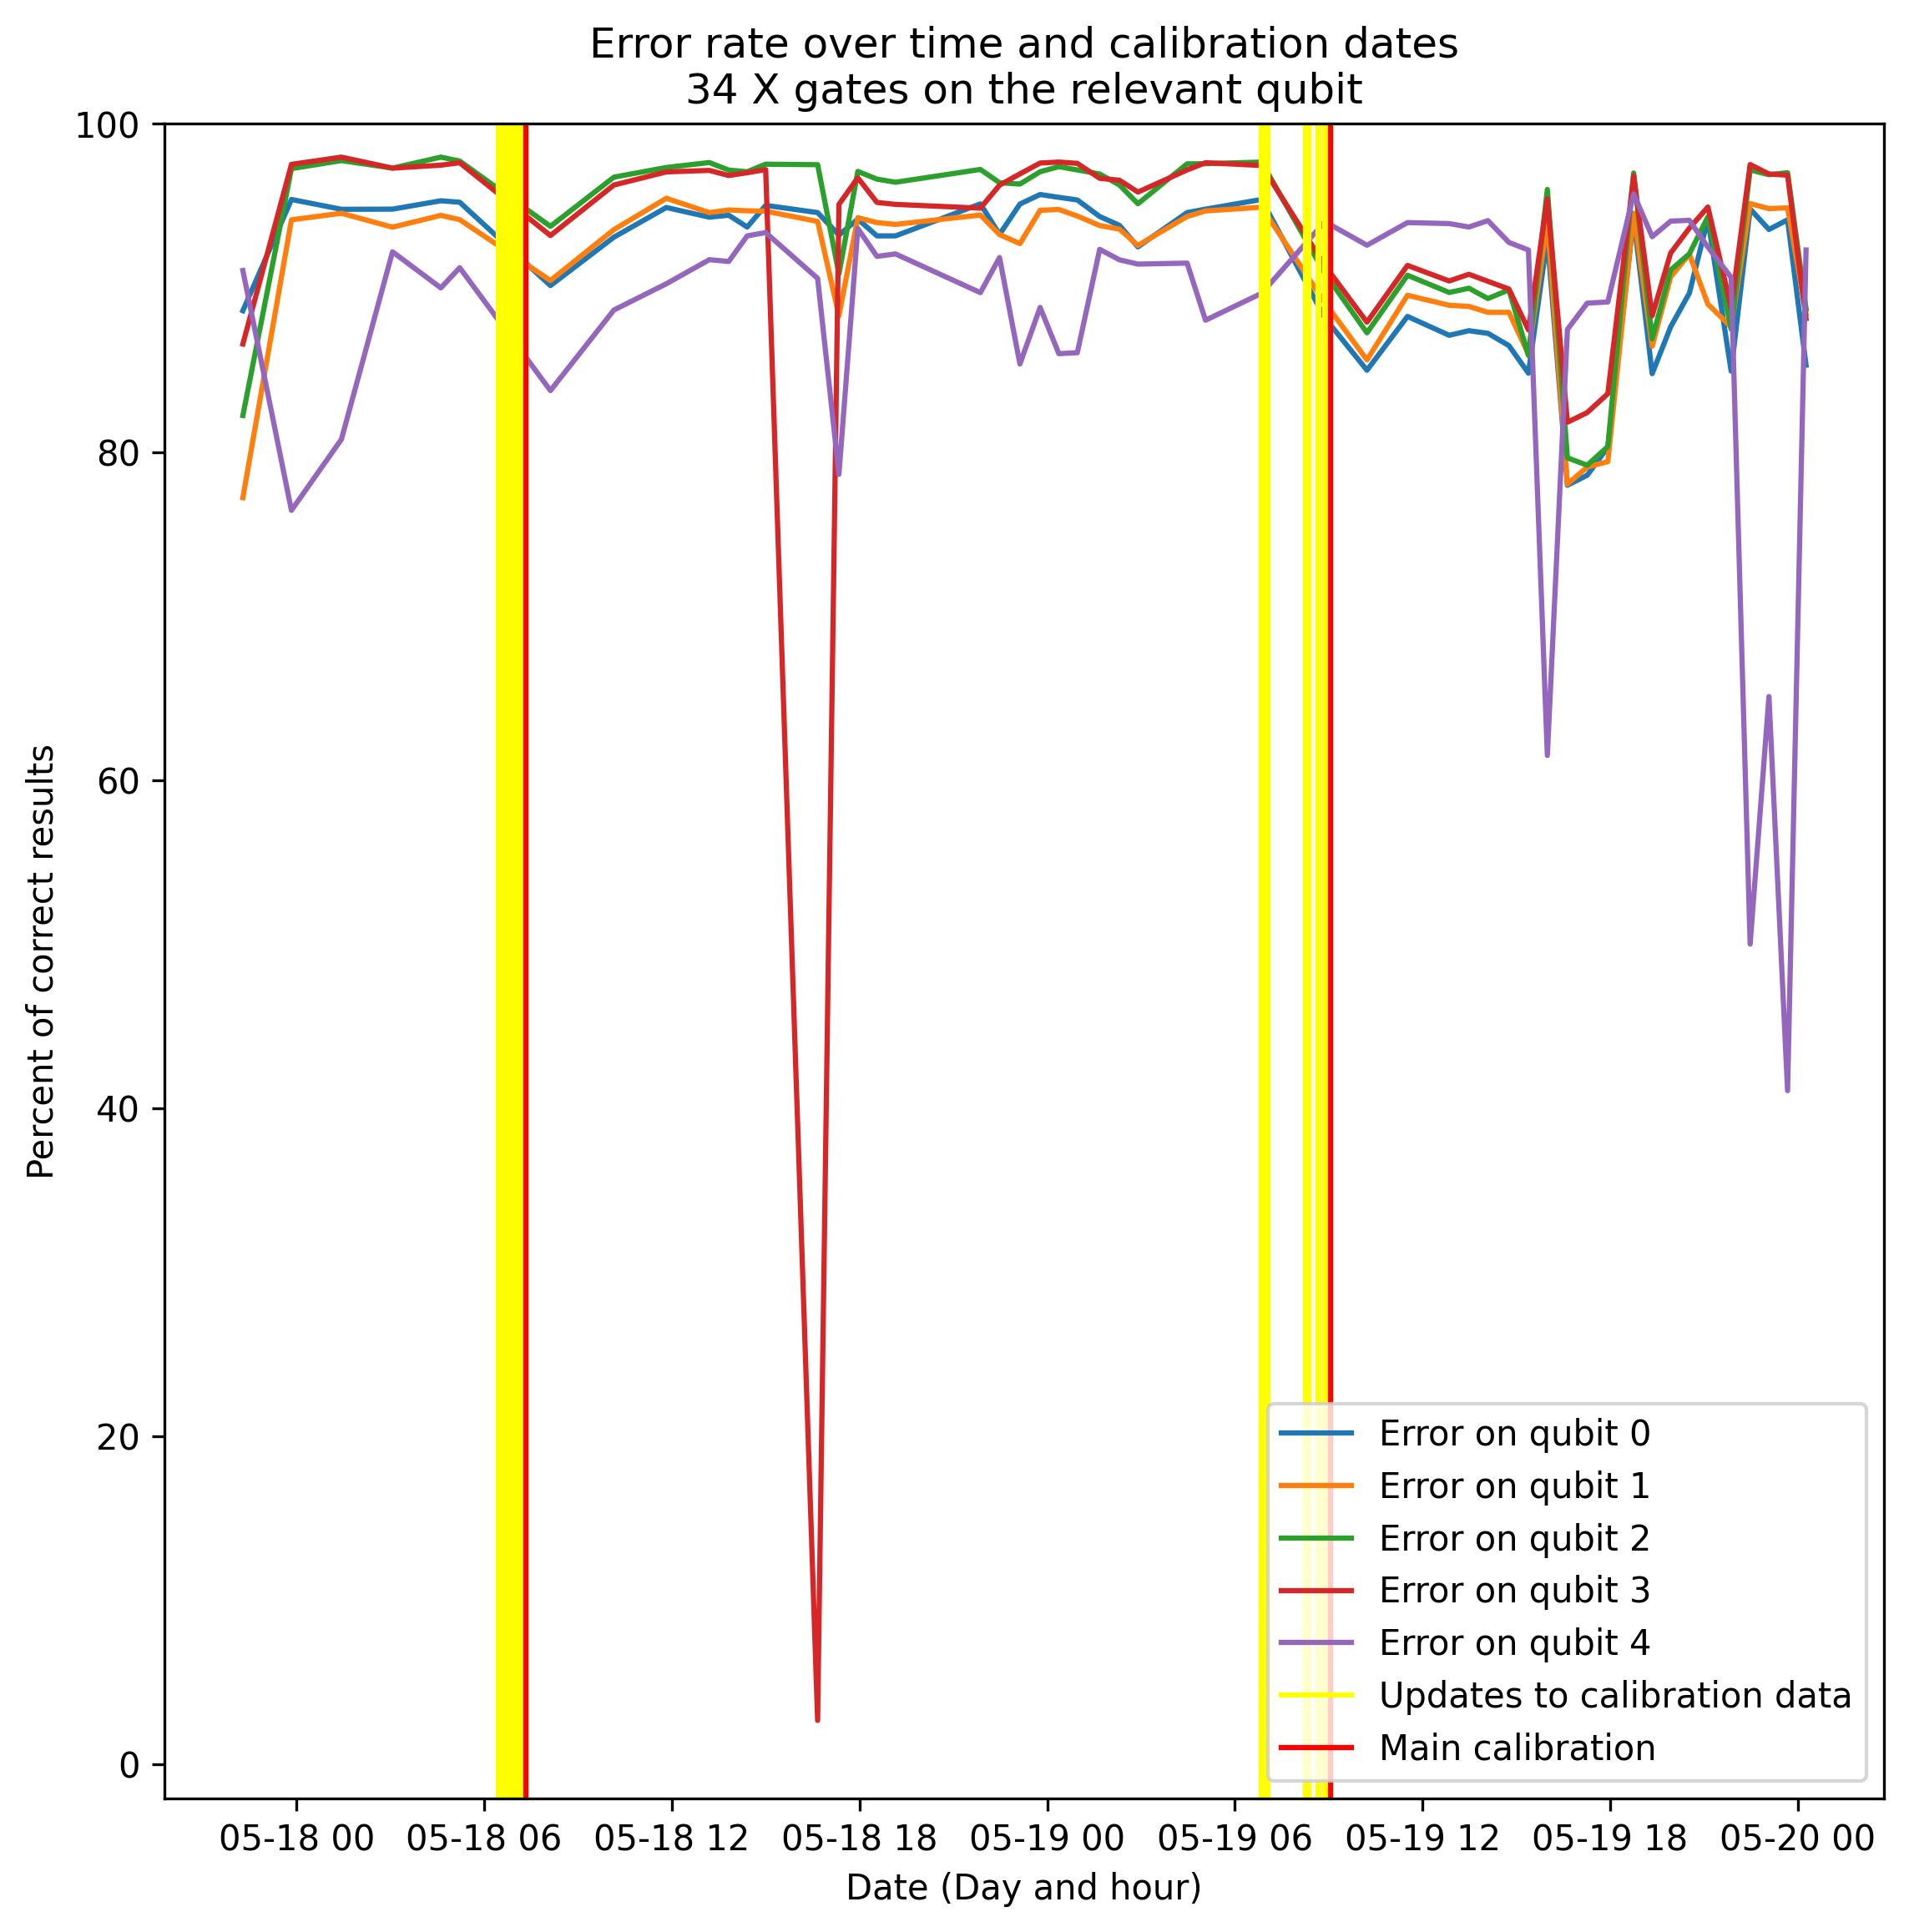

None

In [28]:
s = 0
all_not_s = all_not[:, s, :]
factor = 3
figure_width = 5.90666*factor/2
figure_heigth = figure_width
dpi = 300
figure(figsize=(figure_width, figure_heigth), dpi=dpi)
for i in range(5):
	plt.plot(all_not_dates, all_not_s[:, i]*100, label=f"Error on qubit {i}")
for d in all_calibrations:
	if d > all_not_dates[0]:
		plt.axvline(d, color="yellow", label="Updates to calibration data")
for d in calibration_dates:
	if d > all_not_dates[0]:
		plt.axvline(d, color="red", label="Main calibration")
plt.ylim(top=100)
plt.ylabel("Percent of correct results")
plt.xlabel("Date (Day and hour)")
plt.title("Error rate over time and calibration dates\n34 X gates on the relevant qubit")
#remove duplicate
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
  if label not in newLabels:
    newLabels.append(label)
    newHandles.append(handle)
plt.legend(newHandles, newLabels)
plt.savefig("../images/over_time_calibration.png", bbox_inches='tight')
display(plt.show())

In [14]:
decoherance = []
for m in measures:
	res = []
	for r, p, c in zip(m.result, m.circuit_params, m.circuits):
		if "chained id gates (delay of gates) on all qubits" in p["desc"]:
			expected = p["expected result"]
			e = get_error_rate_per_qubit(r, expected)
			res.append(e)
	decoherance.append(res)
decoherance = np.array(decoherance)
print(decoherance.shape)

(52, 14, 5)


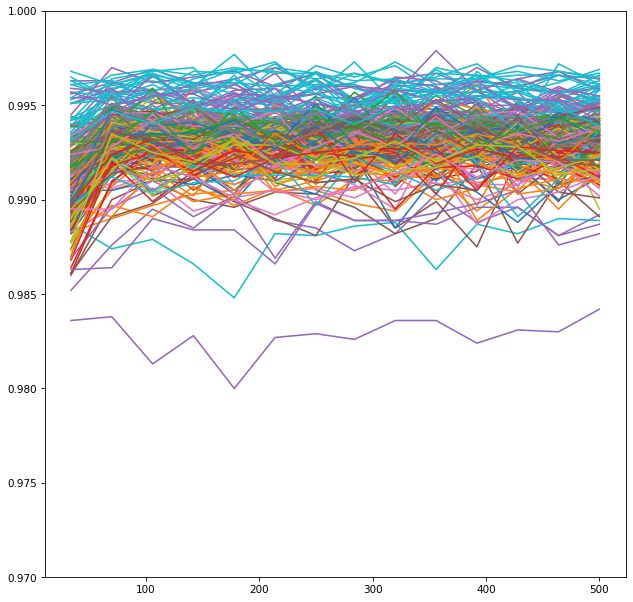

None

In [15]:
#id gates were optimized away
samples = np.linspace(0, 250, 15, dtype=int)[1:]*2
figure(figsize=(10, 10), dpi=75)
for r in decoherance:
	plt.plot(samples, r[:])
#plt.legend()
plt.ylim(0.97,1)
display(plt.show())

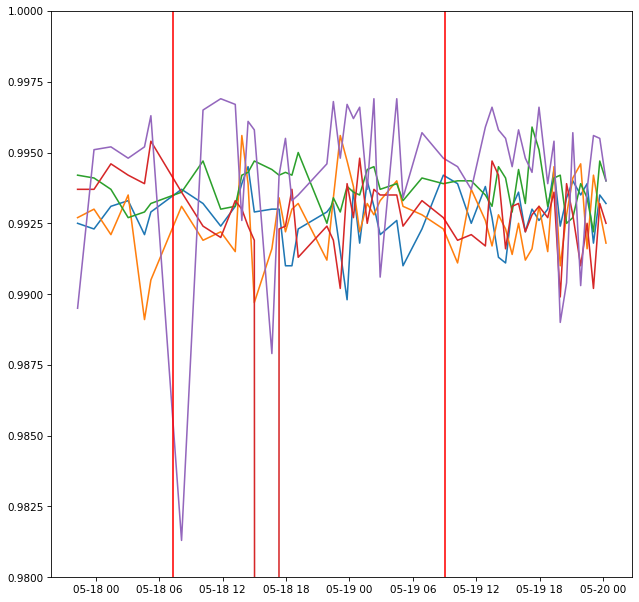

None

In [16]:
s = 2
decoherance_s = [r[s] for r in decoherance]
figure(figsize=(10, 10), dpi=75)
plt.plot(all_not_dates, decoherance_s)
for d in calibration_dates:
	if d > all_not_dates[0]:
		plt.axvline(d, color="red")
plt.ylim(0.98,1)
display(plt.show())